In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import time
import datetime
from typing import Dict, Tuple

# Load raw data

In [2]:
data_raw_filename = "data_raw_fake.csv"

In [3]:
dataset = pd.read_csv(data_raw_filename)

In [4]:
dataset.head().T

,0,1,2,3,4
date,2020-03-27 12:52:08,2020-03-27 14:36:29,2020-03-28 08:47:35,2020-03-28 09:38:40,2020-03-30 17:58:36
restaurant,/be/api/restaurants/181,NaN,/be/api/restaurants/181,NaN,/be/api/restaurants/244
status,-1,-1,-1,-1,-1
total_cost,21.5,0,20.5,0,25.1
rest,&{Long:27.577507 Lat:53.930103},NaN,&{Long:27.577507 Lat:53.930103},NaN,&{Long:27.652157 Lat:53.933624}
dest,&{Long:27.599731 Lat:53.925205},NaN,&{Long:27.599731 Lat:53.925205},NaN,&{Long:27.599731 Lat:53.925205}
courier,NaN,NaN,NaN,NaN,NaN


In [5]:
dataset.dtypes

date           object
restaurant     object
status          int64
total_cost    float64
rest           object
dest           object
courier       float64
dtype: object

In [6]:
dataset.describe()

,status,total_cost,courier
count,502.0,502.000000,0.0
mean,-1.0,13.680558,NaN
std,0.0,14.573024,NaN
min,-1.0,0.000000,NaN
25%,-1.0,0.000000,NaN
50%,-1.0,9.000000,NaN
75%,-1.0,25.975000,NaN
max,-1.0,67.400002,NaN


# Prepare data

## List categorical columns

In [7]:
categorical_columns = ['restaurant']

In [8]:
def split_column(df: pd.DataFrame, name: str):
    df[name+'_long'] = df[name].str.extract("&{Long:(\d+\.\d+)", expand=False).astype('float64')
    df[name+'_lat'] = df[name].str.extract("Lat:(\d+\.\d+)}", expand=False).astype('float64')
    return df.drop([name], axis=1)

In [9]:
def replace_coordinates(df: pd.DataFrame):
    df = split_column(df, "rest")
    df = split_column(df, "dest")
    #df = split_column(df, "courier")
    return df

In [10]:
dataset = replace_coordinates(dataset)

## Geodata

In [11]:
def plot_geodata(dataset: pd.DataFrame): 
    gdf = geopandas.GeoDataFrame(dataset.copy(), 
                                 geometry=geopandas.points_from_xy(dataset.rest_long, dataset.rest_lat))
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'Europe'].plot(color='white', edgecolor='black')

    gdf.plot(ax=ax, color='red',  figsize=(256, 256))

    plt.show()

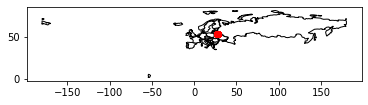

In [12]:
plot_geodata(dataset)

##  Handle N/A values

In [13]:
dataset.isna().sum()

date            0
restaurant    251
status          0
total_cost      0
courier       502
rest_long     251
rest_lat      251
dest_long     251
dest_lat      251
dtype: int64

### Replace other NaN with explicit 'n/a' value

In [14]:
def replace_na_value(dataset: pd.DataFrame):
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
        
        dataset[column] = dataset[column].fillna('n/a')

In [15]:
replace_na_value(dataset)

## Convert columns types
Easier to work with later, handle as generic category

In [16]:
def convert_column_type(dataset, column_name, result_type):
    dataset[column_name] = dataset[column_name].astype(result_type)

In [17]:
convert_column_type(dataset, 'date', 'datetime64')
convert_column_type(dataset, 'restaurant', str)
convert_column_type(dataset, 'status', str)

## State machine - convert events to orders

In [18]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a)) * 1000

In [19]:
data = []

start_date = None
curr_restaurant = None
curr_total_cost = None
curr_distance = None

rest_lat = None
rest_long = None
dest_lat = None
dest_long = None

for index, row in dataset.iterrows():
    restaurant = str(row['restaurant'])
    if 'n/a' in restaurant:
        if curr_restaurant is not None:
            distance = haversine(rest_lat, rest_long, dest_lat, dest_long)
            total_time_sec = (row['date']-start_date).total_seconds()
            data.append([start_date, curr_restaurant, curr_total_cost, distance, total_time_sec])
            
            curr_restaurant = None
    else:
        if curr_restaurant is None:
            curr_restaurant = restaurant
            start_date = row['date']
            curr_total_cost = row['total_cost']
            
            rest_lat = row['rest_lat']
            rest_long = row['rest_long']
            dest_lat = row['dest_lat']
            dest_long = row['dest_long']
        

df = pd.DataFrame(data, columns=['date', 'restaurant', 'total_cost', 'distance_meters', 'total_time_sec'])

In [20]:
df.dtypes

date               datetime64[ns]
restaurant                 object
total_cost                float64
distance_meters           float64
total_time_sec            float64
dtype: object

In [21]:
df.head().T

,0,1,2,3,4
date,2020-03-27 12:52:08,2020-03-28 08:47:35,2020-03-30 17:58:36,2020-04-02 12:19:02,2020-04-03 08:31:33
restaurant,/be/api/restaurants/181,/be/api/restaurants/181,/be/api/restaurants/244,/be/api/restaurants/181,/be/api/restaurants/181
total_cost,21.5,20.5,25.1,22.3,20.2
distance_meters,1553.64,1553.64,3557.68,1553.64,1553.64
total_time_sec,6261,3065,3453,2028,3359


# TODO: extract month, day, weekday, day time; probably better then pure date

# ===========
# Work with processed data

## Encode categorical columns

In [22]:
def encode_categorical_columns(dataset: pd.DataFrame) -> Dict[str, LabelEncoder]:
    encoders = {} 
    for column in categorical_columns:
        if column not in dataset.columns:
            continue
            
        le = LabelEncoder()
        le.fit(dataset[column])

        dataset[column] = le.transform(dataset[column])
        encoders[column]= le
        
    return encoders

In [23]:
encoders = encode_categorical_columns(df)

## Handle date columns
Convert to epoch time

In [24]:
date_columns = ['date']

In [25]:
def convert_date_columns_to_epoch(dataset: pd.DataFrame, timestamp_format="%Y-%m-%d %H:%M:%S"):
    for column in date_columns:
        dataset[column] = (dataset[column] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [26]:
convert_date_columns_to_epoch(df)

## Scale/normalize all columns

In [27]:
def scale_columns(dataset: pd.DataFrame):
    scaler = StandardScaler()
    dataset = scaler.fit_transform(dataset)
    #dataset[values.columns] = scaler.fit_transform(dataset[dataset.columns])

In [28]:
scale_columns(df)

In [29]:
df.head().T

,0,1,2,3,4
date,1.585314e+09,1.585385e+09,1.585591e+09,1.585830e+09,1.585903e+09
restaurant,2.000000e+00,2.000000e+00,6.000000e+00,2.000000e+00,2.000000e+00
total_cost,2.150000e+01,2.050000e+01,2.510000e+01,2.230000e+01,2.020000e+01
distance_meters,1.553645e+03,1.553645e+03,3.557681e+03,1.553645e+03,1.553645e+03
total_time_sec,6.261000e+03,3.065000e+03,3.453000e+03,2.028000e+03,3.359000e+03


In [30]:
df.dtypes

date                 int64
restaurant           int64
total_cost         float64
distance_meters    float64
total_time_sec     float64
dtype: object

In [31]:
def prepare_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    encode_categorical_columns(dataset)
    convert_date_columns_to_epoch(dataset)

    scale_columns(dataset)
    
    return dataset

# =======

# Split dataset

In [32]:
def split_dataset(dataset: pd.DataFrame): 
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]

    return train_test_split(X, y, test_size=0.2, random_state = 0)

In [33]:
X_train, X_test, y_train, y_test = split_dataset(df)

# Train models

In [34]:
models_result = {}

In [35]:
def update_result_print(models_result, model_name, regr, X_test, y_test):
    from sklearn.metrics import r2_score
    
    y_pred = regr.predict(X_test)
    y_test = y_test.values.tolist()
    
    print("y_pred:")
    print(y_pred)
    print("y_test:")
    print(y_test)

    accuracy = r2_score(y_test, y_pred)

    models_result[model_name] = accuracy
    print(f'"{model_name}" has r2_score: {accuracy}') 

In [36]:
def plot_features_importances(regressor, X_train):
    series = pd.Series(regressor.feature_importances_, index=X_train.columns).sort_values(ascending=True)
    series = series.plot(kind='barh', figsize=(10,10))
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.show()

## Random forest

In [37]:
def random_forest(X_train, y_train):
    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=25, n_estimators = 42*5, random_state = 0)

    regr.fit(X_train, y_train)
    
    return regr

y_pred:
[ 6822.80952381  3854.96190476  3039.71428571  3955.81904762
  4365.21428571  5056.2         4018.82440476  4665.54761905
  5384.40952381  4996.47142857  4265.5047619   4397.63333333
  5039.44285714  3714.97619048  3442.74285714  2685.31428571
  4414.38571429  4066.59047619  4103.          3410.75238095
  3987.35714286  4516.8047619   3668.66190476  4555.56190476
  4033.10952381  2778.4047619   3804.49047619  4997.32380952
  4249.63809524 23989.60952381  4871.9         3616.
  3348.25714286  3666.79047619  5412.85714286  5150.31428571
  4393.31428571  3926.2047619   3428.17619048  5458.32380952
  3530.35297619  3347.22857143  3089.62380952  3709.61904762
  3827.35714286  2869.58571429  4263.62857143  4166.85714286
  3853.04285714  4097.50952381  6341.48571429]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697

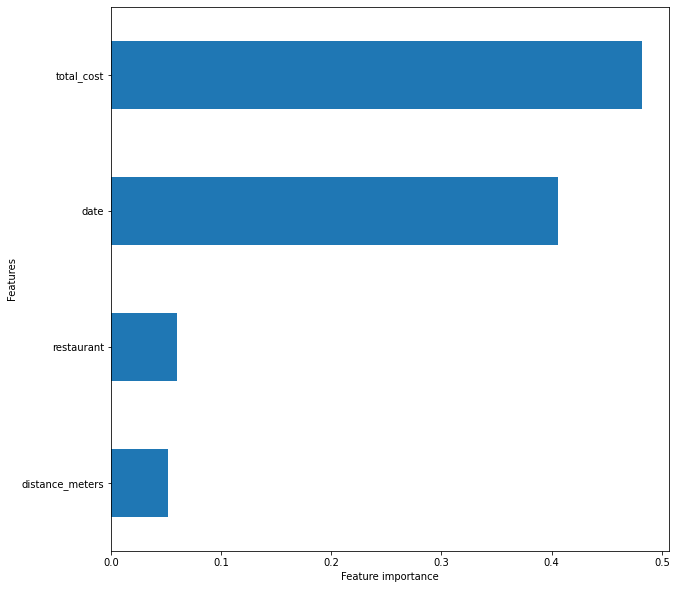

In [38]:
rf_rgr = random_forest(X_train, y_train)
update_result_print(models_result, 'Random forest', rf_rgr, X_test, y_test)
plot_features_importances(rf_rgr, X_train)

## K-Nearest Neighbors

In [39]:
def k_nearest(X_train, y_train):
    from sklearn.neighbors import KNeighborsRegressor
    regr = KNeighborsRegressor(n_neighbors=3)
    
    regr.fit(X_train, y_train)
    
    return regr

In [40]:
k_nearest_regr = k_nearest(X_train, y_train)
update_result_print(models_result, 'K-Nearest Neighbors', k_nearest_regr, X_test, y_test)
#plot_features_importances(k_nearest_regr, X_train)

y_pred:
[5330.66666667 6998.66666667 3048.         3579.         6067.
 4107.         5330.66666667 2643.         3161.66666667 6556.33333333
 4207.         3290.33333333 4315.66666667 4521.         5250.33333333
 4924.66666667 3371.         2750.66666667 3299.66666667 3158.
 3579.         4111.33333333 3021.         4086.33333333 3204.33333333
 2707.66666667 3759.         6047.66666667 5670.66666667 3021.66666667
 3070.         4884.66666667 4086.33333333 3023.         4653.66666667
 4625.66666667 3951.         3439.66666667 1943.33333333 3913.
 3681.66666667 3713.         4315.66666667 5986.33333333 2707.66666667
 3158.         3204.33333333 3576.         4172.66666667 3884.33333333
 3276.66666667]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2868.0, 6280.0, 4562.0, 6

## Linear regression

In [41]:
def linear(X_train, y_train):
    from sklearn.linear_model import LinearRegression
    regr = LinearRegression()
    
    regr.fit(X_train, y_train)
    
    return regr

In [42]:
linear_regr = linear(X_train, y_train)
update_result_print(models_result, 'Linear', linear_regr, X_test, y_test)
#plot_features_importances(linear_regr, X_train)

y_pred:
[5272.46894591 3998.0241963  3951.79751028 3921.83394596 4497.29123863
 3770.95028003 4540.8719025  4770.26369972 4764.62497154 4280.30176037
 3977.74603083 5084.7155702  4162.85188347 3917.70345266 5230.10015749
 4249.37142301 4129.67403786 5157.94749693 3909.79292733 4647.62370979
 5195.95715323 5302.17229303 4880.04103592 5085.97502961 3754.61018945
 4204.48575684 5260.2725676  4202.21829872 4412.54281501 5314.70459579
 4476.9930676  3987.34099821 3936.92227812 4074.89838726 3724.22305907
 5027.12463641 4525.52048365 5373.68070737 4582.14996142 5080.21040383
 3919.06164258 4957.59787791 4188.84683376 4092.44515862 4037.04866972
 4244.97512725 5164.65527895 4913.92321675 4778.97655152 4765.19233098
 4062.68897388]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2

## Ridge regression

In [43]:
def ridge(X_train, y_train):
    from sklearn.linear_model import Ridge
    regr = Ridge(alpha=.5)
    
    regr.fit(X_train, y_train)
    
    return regr

In [44]:
ridge_regr = ridge(X_train, y_train)
update_result_print(models_result, 'Ridge', ridge_regr, X_test, y_test)
#plot_features_importances(ridge_regr, X_train)

y_pred:
[5272.45896849 3998.0354017  3951.80907745 3921.84488487 4497.2933185
 3770.96303689 4540.87332715 4770.26267235 4764.62446368 4280.3031624
 3977.7572568  5084.7074871  4162.85986081 3917.71439708 5230.09269494
 4249.37931802 4129.6820586  5157.94010635 3909.80387843 4647.62450079
 5195.94972484 5302.1647589  4880.03603644 5085.96846682 3754.62296356
 4204.49367118 5260.265515   4202.22621275 4412.54497926 5314.69704937
 4476.99455362 3987.35187123 3936.93386038 4074.90643011 3724.23586202
 5027.11812969 4525.52192327 5373.67310251 4582.15279916 5080.20384747
 3919.07324182 4957.59573032 4188.85476366 4092.45318422 4037.05967359
 4244.98302799 5164.64788169 4913.92111316 4778.97551473 4765.18960947
 4062.69995264]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 286

## Multi-layer perceptron
TODO requires OneHotEncoder

In [45]:
def mlp(X_train, y_train):
    from sklearn.neural_network import MLPRegressor
    regr = MLPRegressor(solver='adam', alpha=1e-5,
                        hidden_layer_sizes=(X_train.columns.size, X_train.columns.size), 
                        max_iter=10, activation='relu',
                        learning_rate_init=.1,
                        random_state=0)
    
    regr.fit(X_train, y_train)
    
    return regr

In [46]:
mlp_regr = mlp(X_train, y_train)
update_result_print(models_result, 'Multi-layer perceptron', mlp_regr, X_test, y_test)
#plot_features_importances(mlp_regr, X_train)

y_pred:
[1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992 1.84004992
 1.84004992 1.84004992 1.84004992]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2868.0, 6280.0, 4562.0, 6794.0, 4480.0, 4664.0, 3663.0, 3157.0, 4643.0, 1495.0, 4336.0, 3077.0, 3853.0, 2280.0, 2977.0, 2315.0, 6921.0, 5380.0, 3954.0]
"Mul

/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Support Vector Machine

In [47]:
def svm(X_train, y_train):
    from sklearn.svm import LinearSVR 
    regr = LinearSVR()
    
    regr.fit(X_train, y_train)
    
    return regr

In [48]:
svm_regr = svm(X_train, y_train)
update_result_print(models_result, 'Support Vector Machine', svm_regr, X_test, y_test)
#plot_features_importances(svm_regr, X_train)

y_pred:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
y_test:
[6024.0, 2366.0, 6392.0, 6118.0, 6003.0, 3329.0, 2475.0, 7667.0, 4817.0, 3882.0, 2681.0, 4520.0, 2809.0, 2058.0, 2604.0, 1553.0, 1753.0, 4131.0, 6369.0, 3255.0, 3666.0, 2139.0, 3333.0, 3304.0, 4125.0, 3094.0, 1697.0, 2989.0, 6228.0, 2612.0, 2416.0, 7733.0, 2868.0, 6280.0, 4562.0, 6794.0, 4480.0, 4664.0, 3663.0, 3157.0, 4643.0, 1495.0, 4336.0, 3077.0, 3853.0, 2280.0, 2977.0, 2315.0, 6921.0, 5380.0, 3954.0]
"Support Vector Machine" has r2_score: -5.696666179579146


/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Results

In [49]:
for k,v in sorted(models_result.items(), key=lambda entry:entry[1], reverse=True):
    print(f'{k:25s} {v}')

Ridge                     -0.25959639418295155
Linear                    -0.25959845996749586
K-Nearest Neighbors       -0.4732840419019384
Random forest             -3.3286256953565694
Multi-layer perceptron    -5.691370274540527
Support Vector Machine    -5.696666179579146
